# model_1
----

Written in the Python 3.7.9 Environment with the following package versions

    * joblib 1.0.1
    * numpy 1.19.5
    * pandas 1.3.1
    * scikit-learn 0.24.2
    * tensorflow 2.5.0

By Nicole Lund 

This Jupyter Notebook builds a ???? predicitive model for Explanet classification from Kepler Exoplanet study data.

Column descriptions can be found at https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html 

**Source Data**

The source data used was provided by University of Arizona's Data Analytics homework assignment. Their data was derived from https://www.kaggle.com/nasa/kepler-exoplanet-search-results?select=cumulative.csv

The full data set was released by NASA at
https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=koi

In [2]:
# Import Dependencies

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Data manipulation
import numpy as np
import pandas as pd
from operator import itemgetter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

# Parameter Selection
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

# Model Development
from sklearn.svm import SVC 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model

# Model Metrics
from sklearn.metrics import classification_report

# Save files
import joblib


# # Ignore deprecation warnings
# import warnings
# warnings.simplefilter('ignore', FutureWarning)

In [3]:
# Set the seed value for the notebook, so the results are reproducible
from numpy.random import seed
seed(1)

# Read the CSV and Perform Basic Data Cleaning

In [4]:
# Import data
df = pd.read_csv("../b_source_data/exoplanet_data.csv")
# print(df.info())

# Drop columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop rows containing null values
df = df.dropna()

# Display data info
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6991 entries, 0 to 6990
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   koi_disposition    6991 non-null   object 
 1   koi_fpflag_nt      6991 non-null   int64  
 2   koi_fpflag_ss      6991 non-null   int64  
 3   koi_fpflag_co      6991 non-null   int64  
 4   koi_fpflag_ec      6991 non-null   int64  
 5   koi_period         6991 non-null   float64
 6   koi_period_err1    6991 non-null   float64
 7   koi_period_err2    6991 non-null   float64
 8   koi_time0bk        6991 non-null   float64
 9   koi_time0bk_err1   6991 non-null   float64
 10  koi_time0bk_err2   6991 non-null   float64
 11  koi_impact         6991 non-null   float64
 12  koi_impact_err1    6991 non-null   float64
 13  koi_impact_err2    6991 non-null   float64
 14  koi_duration       6991 non-null   float64
 15  koi_duration_err1  6991 non-null   float64
 16  koi_duration_err2  6991 

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,FALSE POSITIVE,0,1,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,...,-176,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
2,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,-174,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
3,CONFIRMED,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,...,-211,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
4,CONFIRMED,0,0,0,0,4.134435,1.050000e-05,-1.050000e-05,172.979370,0.001900,...,-232,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


# Pre-processing

## Select data and results

Use `koi_disposition` for the y values

In [5]:
X = df.drop("koi_disposition", axis=1)
y = df["koi_disposition"]
print(X.shape, y.shape)

(6991, 40) (6991,)


## Split dataset into training and testing data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [7]:
X_train.head()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
4954,0,0,0,0,97.942437,0.001183,-0.001183,157.97325,0.00888,-0.00888,...,-198,3.806,0.445,-0.194,2.284,0.726,-1.090,288.53769,51.280384,11.366
4235,0,0,1,1,16.609490,0.000141,-0.000141,147.61311,0.00715,-0.00715,...,-210,4.395,0.105,-0.195,1.050,0.323,-0.162,300.43979,43.930729,14.926
848,0,0,0,0,32.275385,0.000541,-0.000541,149.04600,0.01400,-0.01400,...,-103,4.123,0.182,-0.098,1.483,0.230,-0.316,298.29495,48.775459,14.167
2874,0,1,1,1,0.787120,0.000002,-0.000002,131.73939,0.00190,-0.00190,...,-201,4.481,0.150,-0.100,0.787,0.093,-0.103,295.28110,40.132858,14.964
3016,0,0,0,0,6.963527,0.000039,-0.000039,133.01717,0.00435,-0.00435,...,-201,3.978,0.458,-0.153,1.686,0.413,-0.709,296.10406,42.342590,13.128


## Scale the data 

Use MinMaxScaler

In [8]:
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## One-Hot-Encode the results (y data)

In [9]:
# Encode the y data

# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

In [10]:
print('Unique KOI Disposition Values')
print(y.unique())
print('-----------')
print('Sample KOI Disposition Values and Encoding')
print(y_test[:5])
print(y_test_categorical[:5])

Unique KOI Disposition Values
['CONFIRMED' 'FALSE POSITIVE' 'CANDIDATE']
-----------
Sample KOI Disposition Values and Encoding
4982    FALSE POSITIVE
4866         CANDIDATE
2934    FALSE POSITIVE
5007    FALSE POSITIVE
3869    FALSE POSITIVE
Name: koi_disposition, dtype: object
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


## Determine Features of Influence

### Decision Tree Classifier Method

In [11]:
# Create and score a decision tree classifier
tree_clf = tree.DecisionTreeClassifier()
tree_clf = tree_clf.fit(X_train, y_train)
print('Decision Tree Score:')
print(tree_clf.score(X_train, y_train))

Decision Tree Score:
1.0


In [12]:
# Sort the features by their importance
tree_feature_sort = sorted(zip(X.columns,tree_clf.feature_importances_),key=itemgetter(1), reverse=True)
# tree_feature_sort

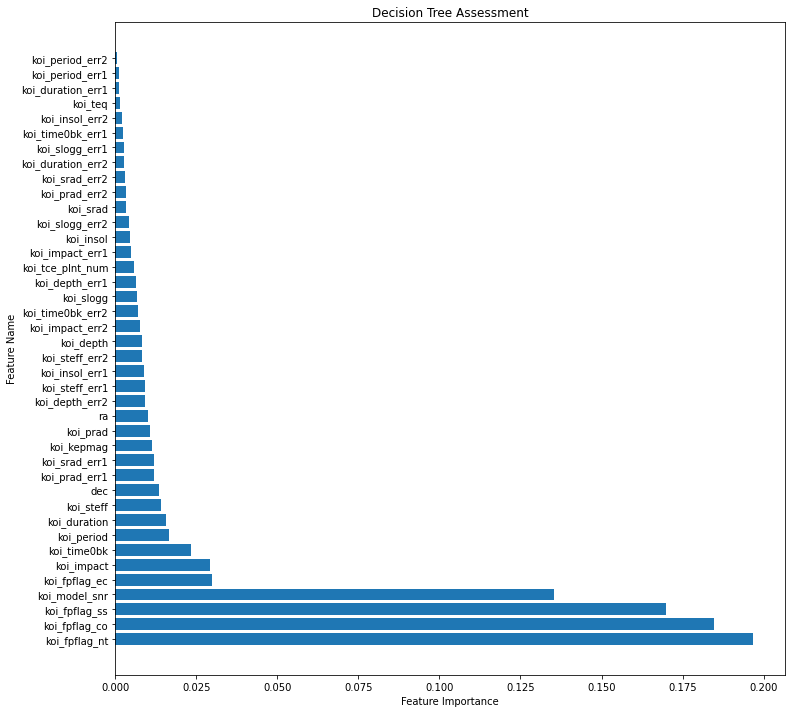

In [13]:
# Plot Decision Tree Feature Importance
fig = plt.figure(figsize=[12,12])
plt.barh(*zip(* (tree_feature_sort)))
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Decision Tree Assessment')
plt.show()

In [14]:
# Decision Tree Features of Interest
tree_features = [feature for feature in tree_feature_sort if feature[1] > 0.1]
tree_features

[('koi_fpflag_nt', 0.19667971475844015),
 ('koi_fpflag_co', 0.18471463196398422),
 ('koi_fpflag_ss', 0.16979964714030865),
 ('koi_model_snr', 0.13525089848327865)]

### Random Forest Classifier Method

In [15]:
# Create and score random forest classifier
rf_clf = RandomForestClassifier(n_estimators=1000)
rf_clf = rf_clf.fit(X_train, y_train)
print('Random Forest Score:')
rf_clf.score(X_train, y_train)

Random Forest Score:


1.0

In [16]:
# Sort the features by their importance
rf_feature_sort = sorted(zip(X.columns,rf_clf.feature_importances_),key=itemgetter(1), reverse=True)
# rf_feature_sort

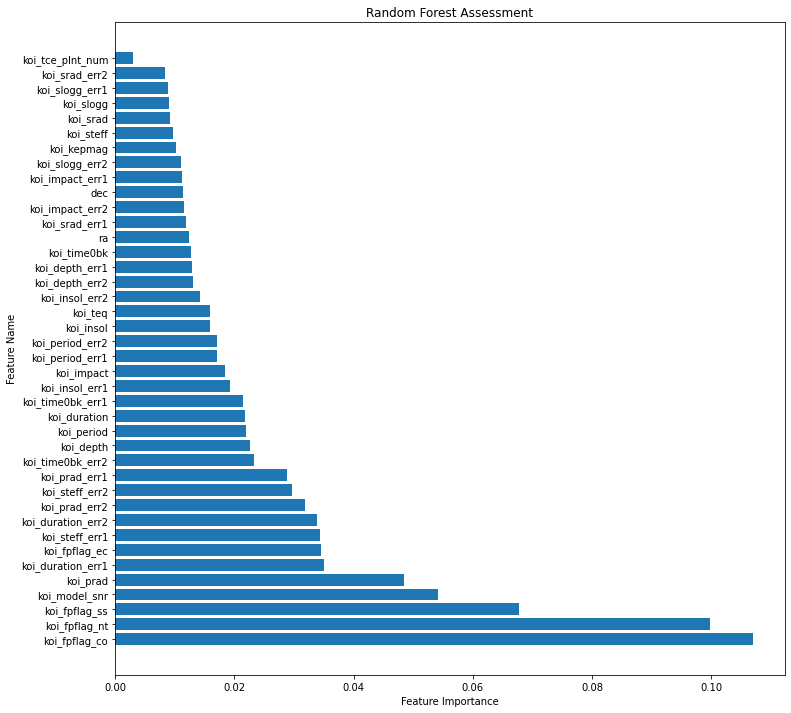

In [17]:
# Plot Random Forest Feature Importance
fig = plt.figure(figsize=[12,12])
plt.barh(*zip(* (rf_feature_sort)))
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Random Forest Assessment')
plt.show()

In [18]:
# Random Forest Features of Interest
rf_features = [feature for feature in rf_feature_sort if feature[1] > 0.04]
rf_features

[('koi_fpflag_co', 0.10696811808472077),
 ('koi_fpflag_nt', 0.09974108014919772),
 ('koi_fpflag_ss', 0.06773677165509455),
 ('koi_model_snr', 0.05409888078141912),
 ('koi_prad', 0.04841533549419281)]

# Select your features (columns)

## Get feature names

In [19]:
selected_tree_feature_names = [feature[0] for feature in tree_features]
selected_rf_feature_names = [feature[0] for feature in rf_features]
selected_feature_names = set(selected_tree_feature_names + selected_rf_feature_names)
selected_feature_names

{'koi_fpflag_co',
 'koi_fpflag_nt',
 'koi_fpflag_ss',
 'koi_model_snr',
 'koi_prad'}

## Refine the model input parameters with the selected features


In [20]:
X_train_reduced = X_train[selected_feature_names]
X_test_reduced = X_test[selected_feature_names]
X_train_reduced.head()

,koi_fpflag_co,koi_fpflag_ss,koi_model_snr,koi_prad,koi_fpflag_nt
4954,0,0,7.8,2.29,0
4235,1,0,12.7,1.82,0
848,0,0,17.9,2.31,0
2874,1,1,43.3,23.81,0
3016,0,0,17.4,1.40,0


## Scale the reduced data 

Use MinMaxScaler

In [21]:
X_reduced_scaler = MinMaxScaler().fit(X_train_reduced)
X_train_reduced_scaled = X_reduced_scaler.transform(X_train_reduced)
X_test_reduced_scaled = X_reduced_scaler.transform(X_test_reduced)

# Train the Linear Regression Model



In [22]:
# Create the model using LinearRegression
model = SVC(kernel='linear')

# Fit the model to the training data and calculate the scores for the training and testing data
model.fit(X_train_reduced_scaled, y_train)

SVC(kernel='linear')

In [23]:
print(f"Training Data Score: {model.score(X_train_reduced_scaled, y_train)}")
print(f"Testing Data Score: {model.score(X_test_reduced_scaled, y_test)}")

Training Data Score: 0.7392192928673615
Testing Data Score: 0.7397521448999047


In [24]:
# Calculate the classification report
predictions = model.predict(X_test_reduced_scaled)
print(classification_report(y_test, predictions,
                            target_names=y.unique()))

                precision    recall  f1-score   support

     CONFIRMED       0.00      0.00      0.00       504
FALSE POSITIVE       0.52      0.98      0.68       574
     CANDIDATE       0.98      0.97      0.98      1020

      accuracy                           0.74      2098
     macro avg       0.50      0.65      0.55      2098
  weighted avg       0.62      0.74      0.66      2098



C:\Users\nlund\anaconda3\envs\PythonDataV2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nlund\anaconda3\envs\PythonDataV2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nlund\anaconda3\envs\PythonDataV2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Hyperparameter Tuning

Use `GridSearchCV` to tune the model's parameters

In [25]:
model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [26]:
# Create the GridSearchCV model
# param_grid = [
#     {'C': [1, 10], 'gamma': [0.0001, 0.001], 'kernel': ['linear']},
#     {'C': [1, 10], 'gamma': [0.0001, 0.001], 'kernel': ['rbf']}
# ]
param_grid = [
    {'C': [1, 5, 10], 'gamma': [0.0001, 0.001, 0.01], 'kernel': ['linear']}
]
grid = HalvingGridSearchCV(model, param_grid, max_resources=1000, min_resources=250, cv=3, n_jobs=-1, verbose=3)

In [27]:
# Train the model with GridSearch
grid.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 250
max_resources_: 1000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 3
n_resources: 750
Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [ ]:
print(grid.best_params_)
print(grid.best_score_)

# Save the Model

In [ ]:
# save your model by updating "your_name" with your name
# and "your_model" with your model variable
# be sure to turn this in to BCS
# if joblib fails to import, try running the command to install in terminal/git-bash
filename = 'model_1.sav'
joblib.dump(grid, filename)